In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
pd.options.mode.chained_assignment = None 

plt.rcParams['figure.figsize'] = (14,6)

In [2]:
def clean(file,csv_name):
    df = pd.read_csv('TG_STAID002759.txt',sep=",", skiprows=19,  index_col=1, header=0, parse_dates=True)
    df = df.rename(columns=lambda x: x.strip())                         # remove white spaces in the column names 
    df['meanT'] = df['TG']*0.1                                          # give back the comma to the temperature numbers
    df.drop(df.head(25567).index, inplace=True)                         # remove all the data up untill 1946
    df.drop(df[['SOUID', 'Q_TG', 'TG']], axis =1, inplace = True)       # drop the useless columns
    df.to_csv(csv_name)             

In [3]:
clean('TG_STAID002759.txt', 'data7.csv')

In [4]:
def split_data(file):
    data = pd.read_csv(file, index_col=0, parse_dates=True)
    train = data[:-365]
    test = data[-365:]
    Xtrain = train.index
    ytrain = train['meanT']
    Xtest = test.index
    ytest = test['meanT']
    return train,test,Xtrain,ytrain,Xtest,ytest

In [5]:
train,test,Xtrain,ytrain,Xtest,ytest = split_data('data7.csv')

In [6]:
def trend_seas(train):
    train['timestep'] = range(len(train))      
    Xtrend = train[['timestep']]                    
    #X = train[['timestep']] 
    y = train['meanT']
    m = LinearRegression()
    m.fit(Xtrend, y)
    trend = m.coef_*12*74  
    print('Trend: '+str(trend)+' °C')            
    print('intercept: ' + str(m.intercept_))
    train['trend'] = m.predict(Xtrend)
    train_trend = train
    train_trend[['meanT', 'trend']].plot()
    return train_trend

Trend: [0.0517445] °C
intercept: 9.011303243293161


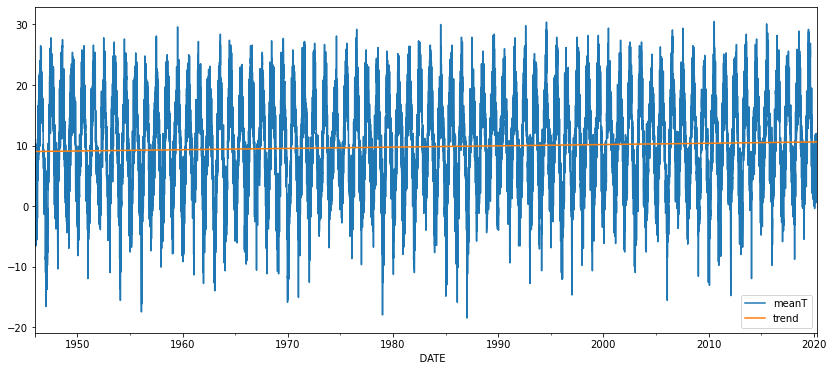

In [7]:
train_trend = trend(train)

In [8]:
def seasonality(train_trend):   
    train_trend['month'] = train_trend.index.month                                      
    dummies = pd.get_dummies(train_trend['month'],prefix='month', drop_first=True) 
    train_trend = train_trend.merge(dummies,left_index = True, right_index=True) 
    Xseason = train_trend.drop(['meanT','trend','month'], axis=1) 
    y = train_trend['meanT'] 
    m = LinearRegression()
    m.fit(Xseason, y)
    print('hey')
    train_trend['tre_sea'] = m.predict(Xseason)
    train_seas = train_trend
    train_seas[['meanT','tre_sea']].plot()
    return train_seas

hey


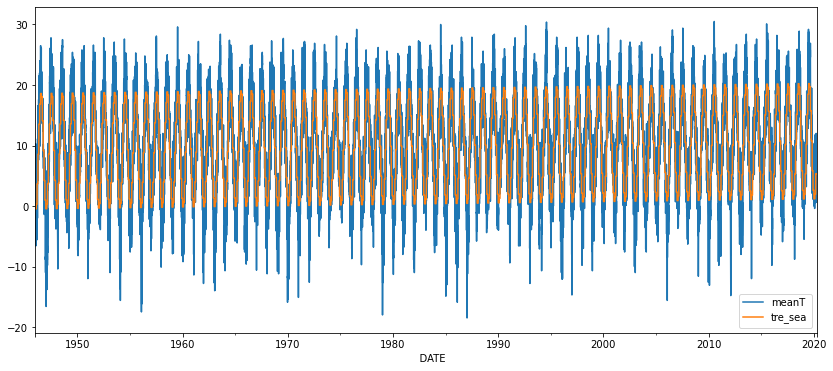

In [9]:
train_seas = seasonality(train_trend)

In [10]:
train_seas

,meanT,timestep,trend,month,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,tre_sea
DATE,,,,,,,,,,,,,,,,
1946-01-01,-3.4,0,9.011303,1,0,0,0,0,0,0,0,0,0,0,0,-0.469696
1946-01-02,-3.0,1,9.011362,1,0,0,0,0,0,0,0,0,0,0,0,-0.469635
1946-01-03,-2.8,2,9.011420,1,0,0,0,0,0,0,0,0,0,0,0,-0.469574
1946-01-04,-2.7,3,9.011478,1,0,0,0,0,0,0,0,0,0,0,0,-0.469512
1946-01-05,1.4,4,9.011536,1,0,0,0,0,0,0,0,0,0,0,0,-0.469451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-27,9.2,27114,10.591259,3,0,1,0,0,0,0,0,0,0,0,0,5.342127
2020-03-28,7.9,27115,10.591317,3,0,1,0,0,0,0,0,0,0,0,0,5.342188
2020-03-29,2.9,27116,10.591375,3,0,1,0,0,0,0,0,0,0,0,0,5.342250


/home/daniel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/daniel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


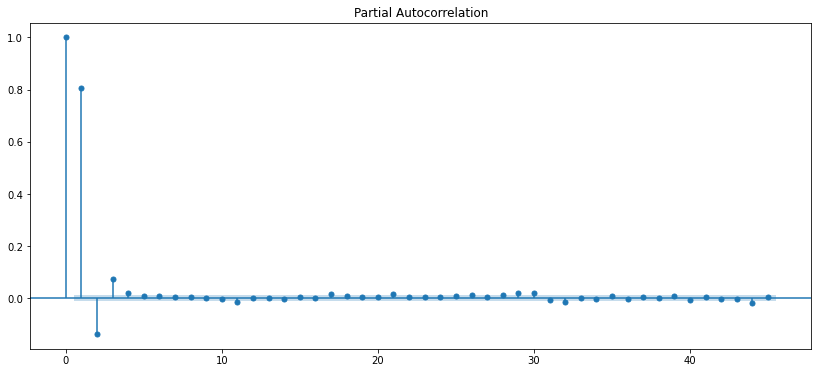

In [14]:
#def hm_lags(file):
train_re = pd.read_csv('remainder.csv', index_col=0, parse_dates=True)
plot_pacf(train_re['remainder'])
mod = ar_select_order(endog=train_re['remainder'], maxlag=12, old_names=False) 

In [15]:
mod.ar_lags

array([1, 2, 3])

In [4]:
def reminder():
    train_re = pd.read_csv('remainder.csv', index_col=0, parse_dates=True)
    plot_pacf(train_re['remainder'])
    mod = ar_select_order(endog=train_re['remainder'], maxlag=10, old_names=False) 
    lags = mod.ar_lags
    return train_re, lags

/home/daniel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/home/daniel/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


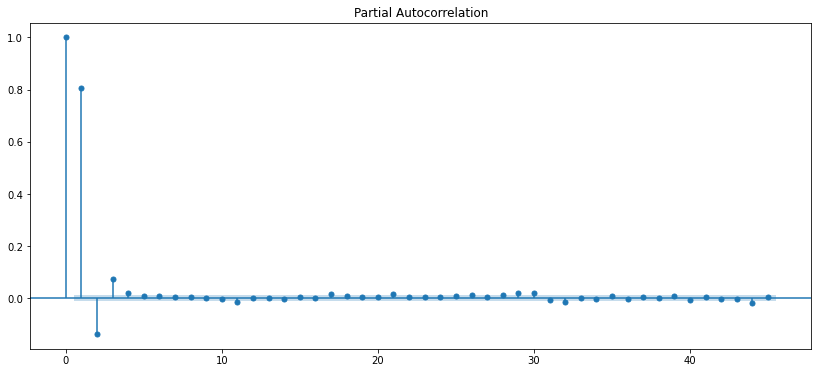

In [10]:
box, lag = reminder()

In [11]:
type(box)

pandas.core.frame.DataFrame